# Building a Travel Planner with LangGraph: A Tutorial

## Overview

This tutorial guides you through the process of creating a simple Travel Planner using LangGraph, a library for building stateful, multi-step applications with language models. The Travel Planner demonstrates how to structure a conversational AI application that collects user input and generates personalized travel itineraries.

## Motivation

In the realm of AI applications, managing state and flow in multi-step processes can be challenging. LangGraph provides a solution by allowing developers to create graph-based workflows that can handle complex interactions while maintaining a clear and modular structure. This Travel Planner serves as a practical example of how to leverage LangGraph's capabilities to build a useful and interactive application.

## Key Components

1. **StateGraph**: The core of our application, defining the flow of our Travel Planner.
2. **PlannerState**: A custom type representing the state of our planning process.
3. **Node Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. **LLM Integration**: Utilizing a language model to generate the final itinerary.

## Method Details

Our Travel Planner follows a straightforward, three-step process:

1. **City Input**:
   - The application prompts the user to enter the city they want to visit.
   - This information is stored in the state.

2. **Interests Input**:
   - The user is asked to provide their interests for the trip.
   - These interests are stored as a list in the state.

3. **Itinerary Creation**:
   - Using the collected city and interests, the application leverages a language model to generate a personalized day trip itinerary.
   - The generated itinerary is presented to the user.

The flow between these steps is managed by LangGraph, which handles the state transitions and ensures that each step is executed in the correct order.

## Conclusion

This tutorial demonstrates how LangGraph can be used to create a simple yet effective Travel Planner. By structuring our application as a graph of interconnected nodes, we achieve a clear separation of concerns and a easily modifiable workflow. This approach can be extended to more complex applications, showcasing the power and flexibility of graph-based designs in AI-driven conversational interfaces.

The Travel Planner serves as a starting point for developers looking to build more sophisticated stateful applications using language models. It illustrates key concepts such as state management, user input handling, and integration with AI models, all within the framework provided by LangGraph.

### Setup and Imports

First, let's import the necessary modules and set up our environment.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_google_genai

In [2]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')


In [3]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=google_api_key)


In [5]:
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from IPython.display import display, Image

from langgraph.graph import MessagesState
from langchain_core.prompts import ChatPromptTemplate

### Define Agent State

We'll define the state that our agent will maintain throughout its operation.

In [6]:
class PlannerState(MessagesState):
    city: str
    interests: List[str]
    travel_date: str
    days: str
    budget: str
    companions: str
    itinerary: str

### Set Up Language Model and Prompts


In [7]:
# llm = ChatOpenAI(model="gpt-4o-mini")


itinerary_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful travel assistant. Create an itinerary for {city} "
        "based on the user's interests: {interests}, traveling on {travel_date} "
        "for {days} days, with a budget of {budget}, "
        "and traveling with {companions}. "
        "Provide a brief, bulleted itinerary."
    ),
    ("human", "Create an itinerary for my trip."),
])

### Define Agent Functions

Now we'll define the main functions that our agent will use: get city, get interests, create itinerary

In [8]:
# 3. NODE FUNCTIONS
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit:")
    user_message = input("Your input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=f"City: {user_message}")],
    }

def input_interests(state: PlannerState) -> PlannerState:
    print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
    user_message = input("Your input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(',')],
        "messages": state['messages'] + [HumanMessage(content=f"Interests: {user_message}")],
    }

def input_travel_date(state: PlannerState) -> PlannerState:
    print("When are you planning to travel?")
    user_message = input("Your input: ")
    return {
        **state,
        "travel_date": user_message,
        "messages": state['messages'] + [HumanMessage(content=f"Travel date: {user_message}")],
    }

def input_days(state: PlannerState) -> PlannerState:
    print("How many days are you planning to travel?")
    user_message = input("Your input: ")
    return {
        **state,
        "days": user_message,
        "messages": state['messages'] + [HumanMessage(content=f"Number of days: {user_message}")],
    }

def input_budget(state: PlannerState) -> PlannerState:
    print("What is your approximate budget for this trip?")
    user_message = input("Your input: ")
    return {
        **state,
        "budget": user_message,
        "messages": state['messages'] + [HumanMessage(content=f"Budget: {user_message}")],
    }

def input_companions(state: PlannerState) -> PlannerState:
    print("Who do you plan on traveling with on your next adventure?")
    user_message = input("Your input: ")
    return {
        **state,
        "companions": user_message,
        "messages": state['messages'] + [HumanMessage(content=f"Companions: {user_message}")],
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    print("\nGenerating your itinerary...")
    response = llm.invoke(
        itinerary_prompt.format_messages(
            city=state['city'],
            interests=", ".join(state['interests']),
            travel_date=state['travel_date'],
            days=state['days'],
            budget=state['budget'],
            companions=state['companions'],
        )
    )
    print("\nFinal Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }

### Create and Compile the Graph

Now we'll create our LangGraph workflow and compile it.

In [9]:
# 4. BUILD THE WORKFLOW GRAPH
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("input_travel_date", input_travel_date)
workflow.add_node("input_days", input_days)
workflow.add_node("input_budget", input_budget)
workflow.add_node("input_companions", input_companions)
workflow.add_node("create_itinerary", create_itinerary)

# The order in which we want the user to be asked these questions
workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "input_travel_date")
workflow.add_edge("input_travel_date", "input_days")
workflow.add_edge("input_days", "input_budget")
workflow.add_edge("input_budget", "input_companions")
workflow.add_edge("input_companions", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

### Display the graph structure

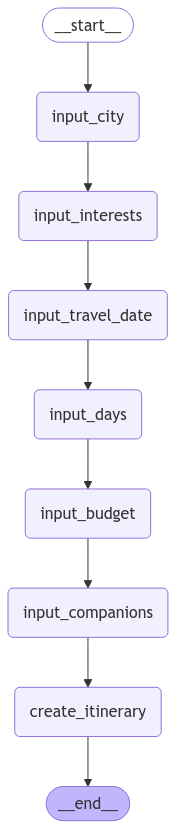

In [10]:
# 5. VISUALIZE THE GRAPH
display(Image(app.get_graph().draw_mermaid_png()))

### Define the function that runs the graph

In [11]:
def run_travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")
    # Initialize an empty state
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "travel_date": "",
        "days": "",
        "budget": "",
        "companions": "",
        "itinerary": "",
    }

    for _state in app.stream(state):
        # Each node function prints prompts/results
        pass


### Use case example

In [12]:
user_request = "I want to plan a trip in Pakistan."
run_travel_planner(user_request)


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Initial Request: I want to plan a trip in Pakistan.

Please enter the city you want to visit:


Your input: Skardu
Please enter your interests for the trip to Skardu (comma-separated):


Your input: Travelling,food exploration
When are you planning to travel?


Your input: tommorrow
How many days are you planning to travel?


Your input: 5 days
What is your approximate budget for this trip?


Your input: 35000
Who do you plan on traveling with on your next adventure?


Your input: freinds



Generating your itinerary...

Final Itinerary:
## Skardu Adventure with Friends: 5-Day Itinerary (Budget: 35000 PKR)

This itinerary balances sightseeing, food exploration, and adventure, keeping in mind a 35000 PKR budget for a group. Prices are estimates and can vary.  Remember to factor in transportation within Skardu (consider hiring a jeep for flexibility).

**Assumptions:**

* You are traveling tomorrow.  This itinerary prioritizes readily available options.
* The budget is shared amongst your group; the per-person cost will depend on group size.
* Accommodation is based on moderately priced guesthouses or homestays.

**Day 1: Arrival & Shangrila Resort Exploration (Budget: 5000 PKR)**

* Arrive at Skardu Airport (SKD).
* Check into your pre-booked guesthouse/homestay near the city center.
* **Afternoon:** Visit Shangrila Resort (entrance fee applies). Enjoy the scenic views and take photos. Explore the resort's grounds.
* **Evening:**  Dinner at a local restaurant, trying tradi

## Run the Agent

Now let's run our agent with a sample request!